In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

import os
import itertools

from utils import *

/home/nivkeren/anaconda3/envs/wave-env/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
AVG_EARTH_RADIUS_KM = 6371.0088
PAZ_WA = {'sensitivity': 2800,
          'zeros': [0j],
          'gain': 1,
          'poles': [-6.2832 - 4.7124j, -6.2832 + 4.7124j]}

NETWORKS = "IS"
STATIONS = ','.join(['MLDT', 'CVYN', 'MNHM', 'SHGL', 'ALMT', 'GLHS', 'ENGV', 'TVR', 'MGDL', 'SPR', 'KNHM', 
                    'RMOT', 'HDNS', 'AMID', 'ZEFT', 'RSPN', 'KSHO', 'KDZV', 'HULT', 'ZRT'])
CHANNELS = str([''.join(ch) for ch in itertools.product("BHSE", "LHN", "?")])[1:-1].replace("'", '')

LAT = 32.80
LON = 35.60
MAX_RAD = 0.4
MIN_MAG = 2.0
DOWNLOAD_INV_CAT = False
DOWNLOAD_EVENTS = False
LOAD_LOCATION = False
PICK = False
CATALOG_PATH = "catalog.xml"
INV_PATH = "inventory.xml"
WAVEFORMS_PATH = 'waveforms'
PICK_DIR_PATH = 'picking'
LOCATION_DIR_PATH = 'location'
SPEEDS = (3.5, 4.0, 4.5)

In [4]:
isr_fdsn = "http://82.102.143.46:8181"
client = Client(isr_fdsn)#, user='niv.keren@gmail.com', password='fdsnisfun1', timeout=240)

In [5]:
my_events = pd.read_csv("events.csv").sort_values(["event time"])
all_events = pd.read_csv("all_events.csv").set_index('event_time')
waveforms_raw = []
waveforms_detrented = []
waveforms_filtered = []

In [6]:
for idx, event in my_events.iterrows():
    cat_event = all_events.loc[event['event time']]
    my_events.loc[idx, "cat_lat"] = cat_event.lat
    my_events.loc[idx, "cat_lon"] = cat_event.lon
    my_events.loc[idx, "cat_mag"] = cat_event.magnitude
my_events = my_events.reset_index(drop=True)
my_events

,event time,cat_lat,cat_lon,cat_mag
0,2018-07-04T01:50:06.667000Z,32.848,35.583,4.797476941 M
1,2018-07-04T01:54:26.532000Z,32.859,35.585,2.552366975 M
2,2018-07-04T03:57:39.993000Z,32.840,35.597,3.288243713 M
3,2018-07-04T19:45:39.428000Z,32.843,35.572,4.761445325 M
4,2018-07-04T19:51:24.449000Z,32.852,35.578,3.821342778 M
5,2018-07-05T04:00:03.956000Z,32.848,35.579,2.975286543 M
6,2018-07-05T16:51:36.987000Z,32.836,35.574,2.957468776 M
7,2018-07-06T05:38:54.227000Z,32.861,35.569,2.760879312 M
8,2018-07-07T02:07:44.383000Z,32.837,35.599,3.993414954 M
9,2018-07-08T12:52:17.385000Z,32.846,35.578,3.099346613 M


### **Download/Load Inventory & Catalog**

In [7]:
if DOWNLOAD_INV_CAT:
    inv, catalog = download_inv_cat(client, my_events["event time"], NETWORKS, STATIONS, CHANNELS, LAT, LON, MAX_RAD, MIN_MAG)
else:
    inv = obspy.read_inventory(INV_PATH, format="STATIONXML")
    print(f"loaded inventory from:{INV_PATH}")
    catalog = obspy.read_events(CATALOG_PATH, format="QUAKEML")
    print(f"loaded catalog from:{CATALOG_PATH}")

loaded inventory from:inventory.xml
loaded catalog from:catalog.xml


### **Download/Load waveform files**

In [8]:
if DOWNLOAD_EVENTS:
    waveforms_raw, waveforms_detrented, waveforms_filtered = download_waveforms(client, my_events, NETWORKS, STATIONS, CHANNELS)
else:
    waveforms_raw, waveforms_detrented, waveforms_filtered = load_waveforms(WAVEFORMS_PATH)

loading mseed file: waveforms/2018-07-04T01:50:01.667000Z-2018-07-04T01:50:36.667000Z.mseed
loading mseed file: waveforms/2018-07-04T01:54:21.532000Z-2018-07-04T01:54:56.532000Z.mseed
loading mseed file: waveforms/2018-07-04T03:57:34.993000Z-2018-07-04T03:58:09.993000Z.mseed
loading mseed file: waveforms/2018-07-04T19:45:34.428000Z-2018-07-04T19:46:09.428000Z.mseed
loading mseed file: waveforms/2018-07-04T19:51:19.449000Z-2018-07-04T19:51:54.449000Z.mseed
loading mseed file: waveforms/2018-07-05T03:59:58.956000Z-2018-07-05T04:00:33.956000Z.mseed
loading mseed file: waveforms/2018-07-05T16:51:31.987000Z-2018-07-05T16:52:06.987000Z.mseed
loading mseed file: waveforms/2018-07-06T05:38:49.227000Z-2018-07-06T05:39:24.227000Z.mseed
loading mseed file: waveforms/2018-07-07T02:07:39.383000Z-2018-07-07T02:08:14.383000Z.mseed
loading mseed file: waveforms/2018-07-08T12:52:12.385000Z-2018-07-08T12:52:47.385000Z.mseed
loading mseed file: waveforms/2018-07-08T18:36:46.126000Z-2018-07-08T18:37:21.12

### **Picking (load or pick)**

In [9]:
index_cols = ["station", "channel"]
events_dfs = []
if PICK:
    for i in range(completed_idx + 1, len(my_events)):
        df_event = event_df(waveforms_raw[i], waveforms_filtered[i], inv, catalog[i])
        df_event.reset_index().to_csv(f'{my_events.loc[i, "event time"]}.csv')
        completed_idx = i
        events_dfs.append(df_event)
else:
    events_csvs = [os.path.join(PICK_DIR_PATH,path) for path in os.listdir(PICK_DIR_PATH) 
                   if os.path.isfile(os.path.join(PICK_DIR_PATH,path)) and path.lower().endswith('.csv')]
    events_csvs.sort()
    events_dfs = [pd.read_csv(path).set_index(index_cols) for path in events_csvs]

## **Location**

---


In [10]:
i = 10

event_data = events_dfs[i].dropna(axis="index", subset=["tp", "ts"])
event_data = event_data.drop(("GLHS", "HH"), axis='index')
num_stations = len(event_data)
(x_stations, y_stations), delta_x, delta_y = conversite(event_data["lat"], event_data["lon"], grid_size=100)
event_data["y"] = y_stations + 5
event_data["x"] = x_stations + 5

wx = int((event_data["x"].max() + 5) / delta_x)
wy = int((event_data["y"].max() + 5) / delta_y)

cat_location = my_events.iloc[i][["cat_lat", "cat_lon"]].values.astype(np.float)
cat_location_x, cat_location_y = absolute2relative((event_data["lat"].min(), event_data["lon"].min()),
                                                   cat_loaction)
cat_location_x += 5
cat_location_y += 5

NameError: name 'cat_loaction' is not defined

In [ ]:
fig = plt.figure(figsize = (15, 20))
# fig, axes = plt.subplots(2, 2, figsize = (15, 20))
fig.suptitle('Stations Map', fontsize=15)

ax = fig.add_subplot(2, 2 ,1, projection = projection)
ax1 = fig.add_subplot(2, 2 ,2)
ax2 = fig.add_subplot(2, 2 ,3)
ax3 = fig.add_subplot(2, 2 ,4)
plot_map(ax, event_data)
ax.scatter(cat_location[1], cat_location[0], zorder=2, marker="*", s=100, color='g')
plot_stations_xy(ax1, event_data, title="XY", x_lim_add=5, y_lim_add=5)
ax1.scatter(cat_location_x, cat_location_y, zorder=2, marker="*", s=100, color='g')
plot_location(ax2, fig, event_data, results["pp"]["mrs_min"], wx, wy, delta_x, delta_y, title="p-p location")
ax2.scatter(cat_location_x, cat_location_y, zorder=2, marker="*", s=100, color='g')
plot_location(ax3, fig, event_data, results["ps"]["mrs_min"], wx, wy, delta_x, delta_y, title="p-s location")
ax3.scatter(cat_location_x, cat_location_y, zorder=2, marker="*", s=100, color='g')
plt.show()

In [ ]:
pairs = list(itertools.combinations(range(num_stations), 2))
time_differences = [UTCDateTime(event_data.iloc[p[0]]["tp"]) - UTCDateTime(event_data.iloc[p[1]]["tp"]) for p in pairs]

In [ ]:
depth=5
vp=2

In [56]:
type(event_data.lat.min())

numpy.float64

### P-P location

In [ ]:
# mean residual sum (storage for residuals)
def pp_location(event_data, wx, wy, delta_x, delta_y, vps=(4.0, ), depths=(5, 6, 7, 8, 9)):
    mrss = []
    mrs_min = np.full((wy, wx), np. inf)
    min_depth = depths[0]
    for vp, depth in itertools.product(vps, depths):
        mrs = np.zeros((wy, wx))

        # xv, yv = np.meshgrid(np.arange(wx) * delta, np.arange(wy) * delta)
        # tt2 = np.sqrt((xv - np.tile(event_data["x"].values, (100, 100, 1)).T)**2 +
        #               (yv - np.tile(event_data["y"].values, (100, 100, 1)).T)**2 +
        #               (0 - depth)**2) / vp

        for y in range(wy):
            for x in range(wx):

                gx = x * delta_x
                gy = y * delta_y
                tt = [0 for i in range(num_stations)]
                r_sum = 0

                for s in range(num_stations):      
                    tt[s]= np.sqrt((event_data.iloc[s]["x"] - gx)**2
                                   + (event_data.iloc[s]["y"] - gy)**2 
                                   + ((event_data.iloc[s]["elevation"] - event_data.iloc[s]["local_depth"]) / 1000 - depth)**2) / vp

                for ci in range(len(pairs)): 
                    #CONSTRAINTS (ci): thickness of constraints
                    #if np.abs((tt[i[ci][0]] - tt[i[ci][1]]) - c[ci]) < 0.1: rSum+=1
                    #RESIDUA
                    r_sum += np.abs((tt[pairs[ci][0]] - tt[pairs[ci][1]]) - time_differences[ci])

        #         tt1 = [np.sqrt((event_data.iloc[s]["x"] - gx)**2 + (event_data.iloc[s]["y"] - gy)**2 + (0 - depth)**2) / vp for s in range(num_stations)]
        #         rSum1 = np.abs([(tt[ci[0]] - tt[ci[1]]) - td for ci, td in zip(pairs, time_differences)]).sum()
        #         print(rSum, rSum1)
                mrs[y][x] = r_sum
        mrss.append(mrs)
        if mrs.min() < mrs_min.min():
            mrs_min = mrs.copy()
            min_depth = depth
    location = np.unravel_index(mrs.argmin(), mrs.shape)
    
    return (*location, min_depth), mrs.min(), vp, mrs_min, mrss

In [ ]:
results_pp = pp_location(event_data, wx, wy, delta_x, delta_y)

In [11]:
def location(event_id, event_data, wx, wy, delta_x, delta_y, vps=(4.0, ), depths=(5, 6, 7, 8, 9)):
    pairs = list(itertools.combinations(range(len(event_data)), 2))
    time_differences = [UTCDateTime(event_data.iloc[p[0]]["tp"]) - UTCDateTime(event_data.iloc[p[1]]["tp"]) for p in pairs]
    results = {}
    for p in ("pp", "ps"):
        results[p] = {"mrs_min": np.inf,
                      "depth": depths[0]}
    for vp, depth in itertools.product(vps, depths):
        mrs = {"pp": np.zeros((wy, wx)),
               "ps": np.zeros((wy, wx))}
        for y in range(wy):
            for x in range(wx):

                gx = x * delta_x
                gy = y * delta_y
                tt = [0 for i in range(num_stations)]

                r_sum_pp = 0
                r_sum_ps = 0

                #calculate S-P residua at this cell(x,y,z) by comparing travel time difference with onset time difference
                # t0 = tp-ttp = ts-tts -> tp-ttp - (ts-tts) = 0 -> (tp-ts) - (ttp - tts) = 0
                # tp - ts := t0 + ttp - (t0 + tts) = ttp - tts 

                for s in range(num_stations):      
                    tt[s] = np.sqrt((event_data.iloc[s]["x"] - gx)**2 
                                  + (event_data.iloc[s]["y"] - gy)**2 
                                  + ((event_data.iloc[s]["elevation"] - event_data.iloc[s]["local_depth"]) / 1000 - depth)**2) / vp            
                    ttp = tt[s]
                    tts = ttp * 1.73
                
                    r_sum_ps += np.abs((tts - ttp) - (UTCDateTime(event_data.iloc[s]["ts"]) - UTCDateTime(event_data.iloc[s]["tp"])))        
                for ci in range(len(pairs)): 
                    #CONSTRAINTS (ci): thickness of constraints
                    #if np.abs((tt[i[ci][0]] - tt[i[ci][1]]) - c[ci]) < 0.1: rSum+=1
                    #RESIDUA
                    r_sum_pp += np.abs((tt[pairs[ci][0]] - tt[pairs[ci][1]]) - time_differences[ci])
                mrs["ps"][y][x] = r_sum_ps
                mrs["pp"][y][x] = r_sum_pp
        
        for p in ("pp", "ps"):
            np.save(f"{event_id}-{p}-{depth}-{vp}", mrs[p])
            if mrs[p].min() < results[p]["mrs_min"]:
                results[p]["mrs"] = mrs[p].copy()
                results[p]["mrs_min"] = mrs[p].min()
                results[p]["depth"] = depth
                results[p]["vp"] = vp
                results[p]["location"] = (np.unravel_index(mrs[p].argmin(), mrs[p].shape))
    
    return results


In [64]:
res_events = []
for i, event in my_events.iterrows():
    event_data = events_dfs[i].dropna(axis="index", subset=["tp", "ts"])
    event_data = event_data.drop(("GLHS", "HH"), axis='index')
    event_id = event["event time"]
    num_stations = len(event_data)
    (x_stations, y_stations), delta_x, delta_y = conversite(event_data["lat"], event_data["lon"], grid_size=100)
    event_data["y"] = y_stations + 5
    event_data["x"] = x_stations + 5

    wx = int((event_data["x"].max() + 5) / delta_x)
    wy = int((event_data["y"].max() + 5) / delta_y)

    cat_location = event[["cat_lat", "cat_lon"]].values.astype(np.float)
    cat_location_x, cat_location_y = absolute2relative((event_data["lat"].min(), event_data["lon"].min()),
                                                       cat_location)
    cat_location_x += 5
    cat_location_y += 5
    my_events.loc[i, "cat_x"] = cat_location_x
    my_events.loc[i, "cat_y"] = cat_location_y
    my_events.loc[i, "delta_x"] = delta_x
    my_events.loc[i, "delta_y"] = delta_y
    
    if LOAD_LOCATION:
        results = load_location(LOCATION_DIR_PATH, event_id, ("pp", "ps"), SPEEDS)
    else:
        results = location(event_id, event_data,
                           wx, wy, delta_x, delta_y, vps=SPEEDS, depths=np.linspace(1, 10, 10))
    
    for key, value in results.items():
        my_events.loc[i, f"{key}_y"] = value["location"][0] * my_events.loc[i, "delta_y"]
        my_events.loc[i, f"{key}_x"] = value["location"][1] * my_events.loc[i, "delta_x"]
        
        min_lat = event_data["lat"].min()
        min_lon = event_data["lon"].min()
        lat, lon = relative2absolute(min_lat, min_lon,
                                     my_events.loc[i, f"{key}_x"] - 5, my_events.loc[i, f"{key}_y"] - 5)
        
        my_events.loc[i, f"{key}_lat"] = lat
        my_events.loc[i, f"{key}_lon"] = lon
        my_events.loc[i, f"{key}_depth"] = value["depth"]
        my_events.loc[i, f"{key}_vp"] = value["vp"]
        
        for idx, station in event_data.iterrows():
             event_data.loc[station.name, f"{key}_distance"] = \
                np.sqrt((station["x"] - my_events.loc[i, f"{key}_x"])**2
                        + (station["y"] - my_events.loc[i, f"{key}_y"])**2
                        + ((station["elevation"] - station["local_depth"]) / 1000 - value["depth"])**2)
    res_events.append(results)
    event_data.to_csv(f"location_{event_id}.csv")
my_events.to_csv("my_events_loaction.csv")
    

KeyboardInterrupt: 

In [ ]:
my_events.head(5)

In [41]:
for idx, res in enumerate(res_events):
    for method, m_res in res.items():
        print(idx, method)
        print(f"depth: {m_res['depth']}")
        print(f"vp: {m_res['vp']}")
    print("-------")

0 pp
depth: 8
vp: 4.5
0 ps
depth: 10
vp: 4.5
-------
1 pp
depth: 5
vp: 4.5
1 ps
depth: 9
vp: 4.5
-------
2 pp
depth: 5
vp: 4.5
2 ps
depth: 6
vp: 4.0
-------
3 pp
depth: 5
vp: 4.5
3 ps
depth: 9
vp: 4.0
-------
4 pp
depth: 8
vp: 4.5
4 ps
depth: 6
vp: 4.0
-------
5 pp
depth: 8
vp: 4.5
5 ps
depth: 7
vp: 4.0
-------
6 pp
depth: 6
vp: 4.5
6 ps
depth: 8
vp: 4.0
-------
7 pp
depth: 10
vp: 4.5
7 ps
depth: 9
vp: 4.5
-------
8 pp
depth: 10
vp: 4.5
8 ps
depth: 9
vp: 4.5
-------
9 pp
depth: 10
vp: 4.5
9 ps
depth: 10
vp: 4.5
-------
10 pp
depth: 10
vp: 4.5
10 ps
depth: 8
vp: 4.5
-------
11 pp
depth: 9
vp: 4.5
11 ps
depth: 10
vp: 4.5
-------
12 pp
depth: 9
vp: 4.5
12 ps
depth: 7
vp: 4.0
-------
13 pp
depth: 10
vp: 4.5
13 ps
depth: 9
vp: 4.5
-------
14 pp
depth: 6
vp: 4.5
14 ps
depth: 5
vp: 3.5
-------
15 pp
depth: 3
vp: 4.5
15 ps
depth: 10
vp: 4.5
-------
16 pp
depth: 4
vp: 4.5
16 ps
depth: 10
vp: 4.5
-------
17 pp
depth: 6
vp: 4.5
17 ps
depth: 6
vp: 4.0
-------
18 pp
depth: 7
vp: 4.5
18 ps
depth: 6


In [87]:
for key, value in results.items():
        my_events.loc[i, f"{key}_x"] = value["location"][1] * delta_x
        my_events.loc[i, f"{key}_y"] = value["location"][0] * delta_y
        #TODO: convert to lat lon location
    #     my_events.iloc[i][f"{key}_ll_location"] = value["location"]
        my_events.loc[i, f"{key}_depth"] = value["depth"]
        for idx, station in event_data.iterrows():
             event_data.loc[station.name, f"{key}_distance"] = \
                np.sqrt((station["x"] - my_events.loc[i, f"{key}_x"])**2
                        + (station["y"] - my_events.loc[i, f"{key}_y"])**2
                        + ((station["elevation"] - station["local_depth"]) / 1000 - value["depth"])**2)

IndexError: tuple index out of range

### **ML Magnitude**

In [34]:
st = waveforms_raw[0]

stz = st.select(channel="EN*", component = "N")
for trz, (idx, sta) in zip(stz, event_data.iterrows()):
    network = trz.stats.network
    station = trz.stats.station
    location = trz.stats.location
    channel = trz.stats.channel
    response = inv.get_response(f"{network}.{station}.{location}.{channel}",
                                trz.stats.starttime)
    
    paz = {"gain": response.response_stages[0].stage_gain,
           "poles": response.get_paz().poles,
           "sensitivity": response.instrument_sensitivity.value,
           "zeros": response.get_paz().zeros}
    st_station = st.select(station=station, channel=f"{channel[0: 2]}?").sort(reverse=True).copy()
    st_station_wa = st_station.copy().simulate(paz_remove=paz, paz_simulate=PAZ_WA,
                                               remove_sensitivity=True, simulate_sensitivity=True, water_level=0)

    for tr in st_station:
        tr.data = tr.data.astype(np.float) / paz["sensitivity"] * PAZ_WA["sensitivity"]
    st_station_filtered = st_station.detrend("linear").filter("bandpass", freqmin=1, freqmax=10, corners = 4, zerophase = True)
    st_station_wa_filtered = st_station_wa.detrend("linear").filter("bandpass", freqmin=1, freqmax=10, corners = 4, zerophase = True)
    
    st_velocity_wa = st_station_wa_filtered.copy().integrate()
    st_velocity = st_station_filtered.copy().integrate()
    ampl = np.abs(st_velocity.max())[0:].max()
    epi_dist = sta["pp_distance"]
    a = 0.018
    b = 2.17
    ml = np.log10(ampl * 1000 / 5) + a * epi_dist / 5 + b
    print(ml)
    epi_dist = sta["ps_distance"]
    a = 0.018
    b = 2.17
    ml = np.log10(ampl * 1000 / 5) + a * epi_dist / 5 + b
    print(ml)
    print("---")

/home/nivkeren/anaconda3/envs/work_env/lib/python3.7/site-packages/obspy/core/inventory/response.py:1876: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)


5.46505916375
5.46850332042
---
5.44864141857
5.45707383055
---
6.23903965229
6.25571999632
---
6.00979399462
6.02634104781
---
5.65340386358
5.66547690147
---
5.90333846389
5.91507303992
---
5.40324602738
5.41708003641
---
5.38803192264
5.39863561747
---
5.05451714364
5.06145958758
---
5.06659053223
5.07281258295
---
4.84057957268
4.85564763554
---
4.99979944439
5.01847790496
---
5.54058091004
5.5528800702
---


In [220]:
inv[0][0][0].response

Equipment:
	Type: Titan
	Description: Titan
	Manufacturer: None
	Vendor: None
	Model: Titan
	Serial number: None
	Installation date: None
	Removal date: None
	Resource id: Sensor/20180426125558.297197.27
	Calibration Dates:


In [210]:
my_events

,event time,cat_lat,cat_lon,cat_mag,cat_x,cat_y,pp_x,pp_y,pp_depth,ps_x,ps_y,ps_depth
0,2018-07-04T01:50:06.667000Z,32.848,35.583,4.797476941 M,13.337718,33.090605,12.581631,33.369229,8.0,12.42237,33.369229,8.0
1,2018-07-04T19:45:39.428000Z,32.843,35.572,4.761445325 M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-07-04T01:54:26.532000Z,32.859,35.585,2.552366975 M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-07-04T03:57:39.993000Z,32.840,35.597,3.288243713 M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-07-04T19:51:24.449000Z,32.852,35.578,3.821342778 M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-07-05T04:00:03.956000Z,32.848,35.579,2.975286543 M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-07-05T16:51:36.987000Z,32.836,35.574,2.957468776 M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-07-06T05:38:54.227000Z,32.861,35.569,2.760879312 M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-07-07T02:07:44.383000Z,32.837,35.599,3.993414954 M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-07-08T12:52:17.385000Z,32.846,35.578,3.099346613 M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


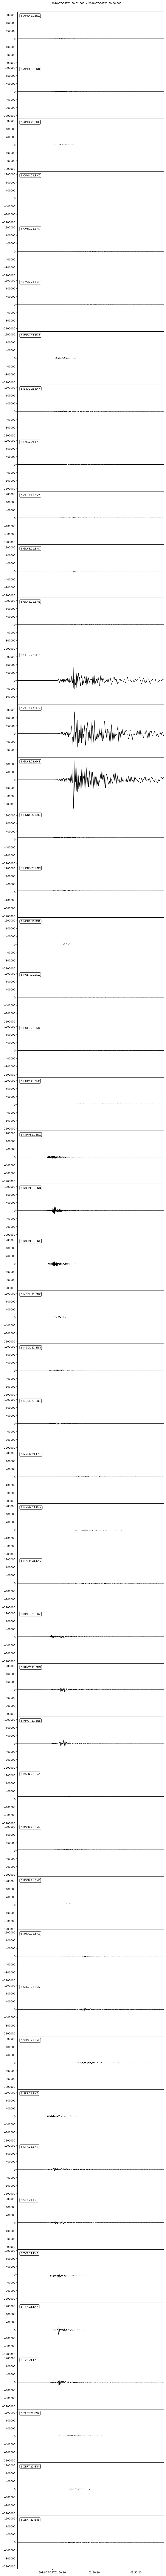

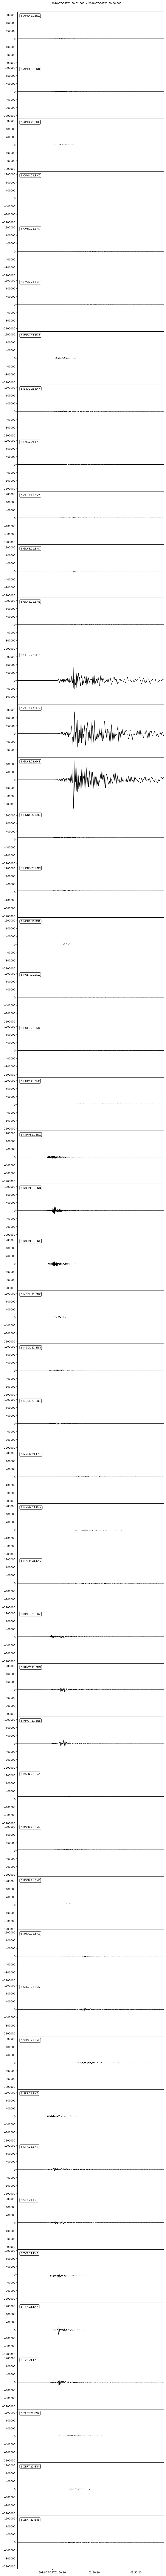

In [144]:
waveforms_raw[i].plot()

In [117]:
for x, xx in event_data.iterrows():
    print(xx)

Unnamed: 0                                 0
lat                                  32.9688
lon                                  35.4937
elevation                                803
local_depth                                0
sampling_rate                            200
cat_tp                               18.1637
cat_ts                                   NaN
cat_distance                             NaN
tp_sta_lta       2018-07-05T04:00:07.730000Z
tp               2018-07-05T04:00:07.670074Z
ts               2018-07-05T04:00:10.506153Z
y                                    46.5179
x                                          5
pp_distance                          16.7978
ps_distance                          16.7265
Name: (ZEFT, EN), dtype: object
Unnamed: 0                                 1
lat                                  32.6636
lon                                  35.5523
elevation                               -132
local_depth                                0
sampling_rate          

In [81]:
trc = st_station[0].copy()
trc.data = trc.data / response.instrument_sensitivity.value

[16643 16641 16643 ..., 15489 15441 15417]
[ 0.0409958   0.04099087  0.0409958  ...,  0.03815321  0.03803498
  0.03797586]


In [ ]:
paz_le3d5s = {'gain': 1.009,
              'poles': [-0.885 + 0.887j,
                        -0.885 - 0.887j,
                        -0.427 + 0j],
              'sensitivity': 167364000.0,
              'zeros': [0j, 0j, 0j]}

inv.get_response()


st.simulate(paz_remove=paz_le3d5s, paz_simulate=paz_wa, water_level=10)

In [29]:
inv.get_response("IS.ZEFT.21.ENZ", UTCDateTime("2018-07-08T18:36:51.126000Z"))
# import pdb; pdb.set_trace()

Channel Response
	From M/S**2 (Acceleration in Meters Per Second Per Second) to COUNTS (None)
	Overall Sensitivity: 405966 defined at 1.000 Hz
	6 stages:
		Stage 1: PolesZerosResponseStage from M/S**2 to V, gain: 1.02
		Stage 2: PolesZerosResponseStage from V to V, gain: 0.995016
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 400000
		Stage 4: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: FIRResponseStage from COUNTS to COUNTS, gain: 1

In [179]:
st = obspy.read("LKBD.MSEED")
# sts = st.copy().simulate(paz_remove="self")
st[0].stats

         network: CH
         station: LKBD
        location: 
         channel: EHN
       starttime: 2012-04-03T02:36:42.996667Z
         endtime: 2012-04-03T02:53:22.996667Z
   sampling_rate: 120.0
           delta: 0.008333333333333333
            npts: 120001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 19, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 233472})

In [14]:
my_events_loaction = pd.read_csv("my_events_loaction.csv")

fig = plt.figure(figsize = (15, 20))
# fig, axes = plt.subplots(2, 2, figsize = (15, 20))
fig.suptitle('Stations Map', fontsize=15)

ax = fig.add_subplot(2, 2 ,1, projection = projection)
ax1 = fig.add_subplot(2, 2 ,2)
ax2 = fig.add_subplot(2, 2 ,3)
ax3 = fig.add_subplot(2, 2 ,4)
plot_map(ax, event_data)
ax.scatter(cat_location[1], cat_location[0], zorder=2, marker="*", s=100, color='g')
plot_stations_xy(ax1, event_data, title="XY", x_lim_add=5, y_lim_add=5)
ax1.scatter(cat_location_x, cat_location_y, zorder=2, marker="*", s=100, color='g')
plot_location(ax2, fig, event_data, results["pp"]["mrs_min"], wx, wy, delta_x, delta_y, title="p-p location")
ax2.scatter(cat_location_x, cat_location_y, zorder=2, marker="*", s=100, color='g')
plot_location(ax3, fig, event_data, results["ps"]["mrs_min"], wx, wy, delta_x, delta_y, title="p-s location")
ax3.scatter(cat_location_x, cat_location_y, zorder=2, marker="*", s=100, color='g')
plt.show()

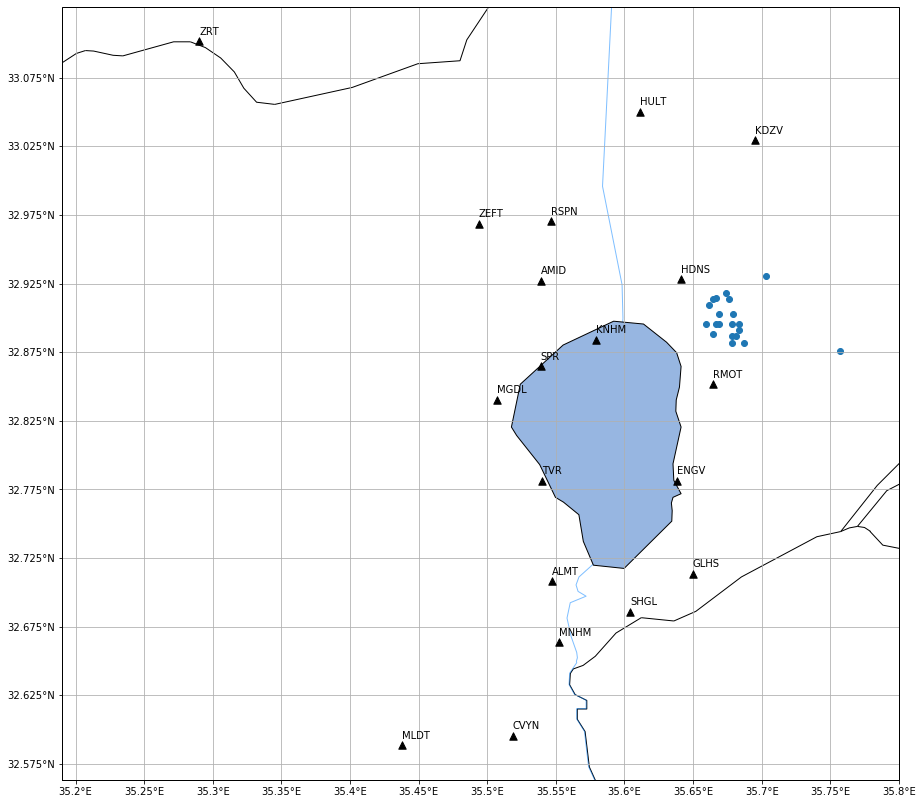

In [63]:
lon_margin, lat_margin = 0.1, 0.025
ticks_diff = 0.05
station_size, location_size = 55, 100
label_offset_x, label_offset_y = 0, 0.005

fig = plt.figure(figsize = (15, 20))
projection = ccrs.PlateCarree()
ax = plt.subplot(projection=projection)

ax.set_extent([stations_df["longitude"].min() - lon_margin,
               stations_df["longitude"].max() + lon_margin,
               stations_df["latitude"].min() - lat_margin,
               stations_df["latitude"].max() + lat_margin],
              crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'), edgecolor='k', facecolor=(0, 0.85, 1))
ax.add_feature(cfeature.LAND.with_scale('10m'), edgecolor='k', alpha=0.0, facecolor='none')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='k')
ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='k')
ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor=(0, 0.5, 1), alpha=0.5)
ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor='k', alpha=1)

ax.grid(True)
ax.set_xticks(
    np.arange(stations_df["longitude"].min().round(1) - lon_margin, stations_df["longitude"].max().round(1) + lon_margin,
              ticks_diff),
    crs=ccrs.PlateCarree())
ax.set_yticks(
    np.arange(stations_df["latitude"].min().round(1) - lat_margin, stations_df["latitude"].max().round(1) + lat_margin,
              ticks_diff),
    crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.scatter(stations_df["longitude"], stations_df["latitude"], marker='^', s=station_size, c='k', zorder=2)
for station in stations_df.iterrows():
    ax.text(station[1]["longitude"] + label_offset_x, station[1]["latitude"] + label_offset_y, station[1]["station"])
ax.scatter(my_events_loaction["pp_lon"], my_events_loaction["pp_lat"])

In [58]:
columns = ["network", "station", "latitude", "longitude", "elevation"]
stations_df = pd.DataFrame(columns=columns)
for network in inv:
    for i, station in enumerate(network):
        stations_df.loc[i, ["network", "station", "latitude", "longitude", "elevation"]] = \
            network.code, station.code, station.latitude.real, station.longitude.real, station.elevation
stations_df = stations_df.astype({"latitude" : "float64",
                                  "longitude" : "float64",
                                  "elevation" : "float64")

In [49]:
print(station.latitude.real, station.latitude.imag)

32.968786 0.0


----